<a href="https://colab.research.google.com/github/SikanderBinMukaram/ImageReconstructionAutoEncoder/blob/main/InputReconstructionFromAverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconstruction of input Images from the Average**

*   Task: Average two images from CIFAR10 dataset and reconstruct the input images.
* I tried using single decoder for CIFAR10, but couldn't get good results. 
* I tried training with MSE loss just but the results were not good.
* Also I tried available models from different github directories to check if we can get any results to seperate images (tried variational autoencoder for mnist to check if I can seperate an average image)
* Tried Deep models like vgg & resnet for random images (not CIFAR and code was available on github just did it for checking if deep networks work) but couldn't get any good results. 
* Didn't try GAN's but came over a stackoverflow where there was mentioned that this wasn't helping either.
* Lastly I tried 2 decoders and single encoder, results were not good for MSE but were good for combination of SSIM and L1 Loss. 
* Here is the final code for training, validating and testing a 2 decoder model for the given task. 
* I have also provided a link to a pre-trained model which could be directly used for Evaluation. 
* For a pretrained model for 400 epochs I got: MSE :0.0323, PSNR: :15.3428, SSIM: :0.5799
* For a pretrained model for 100 epochs I got: MSE :0.0313, PSNR: :15.5046, SSIM: :0.5985


* Added comments to code
* Showed the evaluation examples. The output image has 5 images i.e
      Average Image | Input 1 | Reconstructed Input 1 | Input 2 | Reconstructed Input 2





##Imports

In [ ]:
#imports
import os
import torch
import gdown 
import torchvision
import numpy as np
from torch import nn
from tqdm import tqdm
# !pip install pytorch_msssim
from pytorch_msssim import ssim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.metrics import structural_similarity as ssimm
import cv2
from google.colab.patches import cv2_imshow



In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1" #using specific gpu

In [ ]:
#Directory for saving intermediate images & models
if not os.path.exists('./ssim2Decoders'):
    os.mkdir('./ssim2Decoders')

##Model 
An autoencoder with two decoders, one for each output.

In [ ]:
#Model & Functions

#image values are clamped in range of 0 & 1 to get rid of negative values 
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x


class Autoencoder_2decoders(nn.Module):
    def __init__(self):
        super(Autoencoder_2decoders,self).__init__()

        #encoder layers
        self.conv_1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)

        self.conv_2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)

        self.conv_3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)

        self.conv_4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)

        self.conv_5 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.batchNorm5 = nn.BatchNorm2d(256)


        # decoder 1 layers
        self.deconv_1_d1 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm1_d1 = nn.BatchNorm2d(256)
        
        self.deconv_2_d1 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm2_d1 = nn.BatchNorm2d(128)
        
        self.deconv_3_d1 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm3_d1 = nn.BatchNorm2d(64)
        
        self.deconv_4_d1 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm4_d1 = nn.BatchNorm2d(32)
        
        self.deconv_5_d1 = nn.ConvTranspose2d(32, 3, 3,  padding=1)


        # decoder 1 layers
        self.deconv_1_d2 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm1_d2 = nn.BatchNorm2d(256)
        
        self.deconv_2_d2 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm2_d2 = nn.BatchNorm2d(128)
        
        self.deconv_3_d2 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm3_d2 = nn.BatchNorm2d(64)
        
        self.deconv_4_d2 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        self.batchNorm4_d2 = nn.BatchNorm2d(32)
        
        self.deconv_5_d2 = nn.ConvTranspose2d(32, 3, 3,  padding=1)

    def forward(self, x):
      #encoder
       conv_b1 = F.relu(self.batchNorm1(self.conv_1(x))) # will be used as Skip connection 1
       conv_b2 = F.relu(self.batchNorm2(self.conv_2(conv_b1))) # will be used as Skip connection 2
       conv_b3 = F.relu(self.batchNorm3(self.conv_3(conv_b2)))  # will be used as Skip connection 3 
       conv_b4 = F.relu(self.batchNorm4(self.conv_4(conv_b3))) 
       conv_b5 = F.relu(self.batchNorm5(self.conv_5(conv_b4)))

      #decoder 1
       deconv_b1_d1 = F.relu(self.batchNorm1_d1(self.deconv_1_d1(conv_b5)))
       concat_1_d1 = torch.cat((deconv_b1_d1, conv_b3),1)                   # Skip connection 3

       deconv_b2_d1 = F.relu(self.batchNorm2_d1(self.deconv_2_d1(concat_1_d1)))
       concat_2_d1 = torch.cat((deconv_b2_d1, conv_b2),1)                   # Skip connection 2

       deconv_b3_d1 = F.relu(self.batchNorm3_d1(self.deconv_3_d1(concat_2_d1)))
       concat_3_d1 = torch.cat((deconv_b3_d1, conv_b1),1)                   # Skip connection 1

       deconv_b4_d1 = F.relu(self.batchNorm4_d1(self.deconv_4_d1(concat_3_d1)))

       deconv_b5_d1 = F.tanh(  self.deconv_5_d1(deconv_b4_d1))
       
      #decoder 2
       deconv_b1_d2 = F.relu(self.batchNorm1_d2(self.deconv_1_d2(conv_b5)))
       concat_1_d2 = torch.cat((deconv_b1_d2, conv_b3),1)                   # Skip connection 3
       
       deconv_b2_d2 = F.relu(self.batchNorm2_d2(self.deconv_2_d2(concat_1_d2)))
       concat_2_d2 = torch.cat((deconv_b2_d2, conv_b2),1)                   # Skip connection 2

       deconv_b3_d2 = F.relu(self.batchNorm3_d2(self.deconv_3_d2(concat_2_d2)))
       concat_3_d2 = torch.cat((deconv_b3_d2, conv_b1),1)                   # Skip connection 1

       deconv_b4_d2 = F.relu(self.batchNorm4_d2(self.deconv_4_d2(concat_3_d2)))

       deconv_b5_d2 = F.tanh(  self.deconv_5_d2(deconv_b4_d2))
       
       return deconv_b5_d1, deconv_b5_d2      # We get two outputs, one from each decoder





##Function for Evaluation and Validation

In [ ]:

# pass true when testing else false for validation
def Evaluate(dataloader_, model, isTest):

  MSE = nn.MSELoss()  #define mean square error loss

  sample_idx = 0      # samples to store or show
  total_mse = 0       # total mse error
  total_ssim = 0      # total structure similarity error
  total_psnr = 0      # total PSNR error

  for data in tqdm(dataloader_, position=0, leave=True):
      batch, _ = data       # Get a batch

      # split batch into 2, We then average corresponding images 
      # from each split to have an average input
      input1 = batch[0:1]
      input2 = batch[1:]
      
      # Average images to be used as input to our model
      avg_input = (input1+input2) / 2 


      avg_input = (avg_input).cuda()
      input1 = (input1).cuda()
      input2 = (input2).cuda()

      # ===================forward=====================
      # with torch.no_grad():
      output1, output2 = model(avg_input)   #we get two outputs from the models which will be used for evaluation

      #Normalise the images to have positive values between 0 & 1
      out1 = to_img(output1.cpu().data)
      in1  = to_img(input1.cpu().data)
      out2 = to_img(output2.cpu().data)
      in2  = to_img(input2.cpu().data)

      # we check if the output 1 is more closer to input 1 or input 2
      mse_t1 = MSE(out1,in1)
      mse_t2 = MSE(out1,in2)
            
      # If output is more closer to input 1, we get a reconstructed input 1 at output 1
      if mse_t2 > mse_t1:

        #MSE 
        mse_in1 = mse_t1
        mse_in2 = MSE(out2,in2)
        mse = mse_in1 + mse_in2

        #PSNR
        psnr_in1 = 10 * torch.log10(1 / mse_in1)
        psnr_in2 = 10 * torch.log10(1 / mse_in2)
        psnr = psnr_in1 + psnr_in2
        

        #SSIM -  for ssim, I had to make changes to the dimensions in 
        #order to use the ssim function provided by skimage.metrics
        out1,out2 = np.moveaxis(np.squeeze(out1.detach().numpy()), 0, -1),np.moveaxis(np.squeeze(out2.detach().numpy()), 0, -1)
        in1 , in2 = np.moveaxis(np.squeeze(in1.detach().numpy()), 0, -1),np.moveaxis(np.squeeze(in2.detach().numpy()), 0, -1)
        ssim_n1 = ssimm(out1, in1, multichannel=True)
        ssim_n2 = ssimm(out2, in2, multichannel=True)
        ssim = ssim_n1 + ssim_n2

      else:

        # Else if output 1 is more similar to input 2, we get reconstrcted input 1 at output 2
        #MSE 
        mse_in1 = mse_t2
        mse_in2 = MSE(out2,in1)
        mse = mse_in1 + mse_in2

        #PSNR
        psnr_in1 = 10 * torch.log10(1 / mse_in1)
        psnr_in2 = 10 * torch.log10(1 / mse_in2)
        psnr = psnr_in1 + psnr_in2

        #SSIM -  for ssim, I had to make changes to the dimensions in 
        #order to use the ssim function provided by skimage.metrics
        out1,out2 = np.moveaxis(np.squeeze(out1.detach().numpy()), 0, -1),np.moveaxis(np.squeeze(out2.detach().numpy()), 0, -1)
        in1 , in2 = np.moveaxis(np.squeeze(in1.detach().numpy()), 0, -1),np.moveaxis(np.squeeze(in2.detach().numpy()), 0, -1)       
        ssim_n1 = ssimm(out1, in2, multichannel=True)
        ssim_n2 = ssimm(out2, in1, multichannel=True)
        ssim = ssim_n1 + ssim_n2
            
      total_mse += mse
      total_psnr+= psnr 
      total_ssim+= ssim

      if isTest:
        #save & show samples for evaluation
        sample_idx+=1
        if sample_idx % 300 == 0:
          # Checking if output1 is similar to input 1 or input 2
          if mse_t2 > mse_t1:
            out = torch.cat((avg_input,input1,output1,input2,output2),0)
          else:
            out = torch.cat((avg_input,input1,output2,input2,output1),0)
          out = to_img(out.cpu().data)
          save_image(out, './ssim2Decoders/Test_image_out1_{}.png'.format(sample_idx))
          example = cv2.imread('./ssim2Decoders/Test_image_out1_{}.png'.format(sample_idx), cv2.IMREAD_UNCHANGED)
          cv2_imshow(example)            

  print('\n\nMSE :{:.4f}, PSNR: :{:.4f}, SSIM: :{:.4f}\n\n'
        .format(total_mse/len(test_dataloader)/2,total_psnr/len(test_dataloader)/2, total_ssim/len(test_dataloader)/2 ))

##Hyperparameters

In [ ]:
#Hyperparameters

num_epochs = 50 #400
batch_size = 8
learning_rate = 1e-3


##Dataloaders

In [ ]:
#Data Loaders
#image transformations
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5), (0.5))
])

#training & validation data
train_dataset = CIFAR10('../data/', train=True, download=True, transform=img_transform)
valid_dataset = CIFAR10('../data/', train=True, download=True, transform=img_transform)

#Spliting into validation and training datasets
# we don't have a direct method to get validation dataset so I had 
# to split the training data myself using  SubsetRandomSampler
valid_size = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler=train_sampler ,shuffle=False)
valid_dataloader = DataLoader(train_dataset,batch_size=2, sampler=valid_sampler ,shuffle=False)

#testing data
test_dataset = CIFAR10('../data/', train=False, download=True, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##Using Pre-trained model

In [ ]:
#use a pretrained model if available else a New model

model = Autoencoder_2decoders().cuda()

if not os.path.exists('./PretrainModels'):
    os.mkdir('./PretrainModels')

#uncomment if finetuning with a pretrained model
# else:
#     model.load_state_dict(torch.load('./PretrainModels/AE_model_{}.pth'.format(num_epochs)))


#check model parameters
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          18,496
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 256, 2, 2]         295,168
       BatchNorm2d-8            [-1, 256, 2, 2]             512
            Conv2d-9            [-1, 256, 2, 2]         590,080
      BatchNorm2d-10            [-1, 256, 2, 2]             512
  ConvTranspose2d-11            [-1, 256, 4, 4]         590,080
      BatchNorm2d-12            [-1, 256, 4, 4]             512
  ConvTranspose2d-13            [-1, 128, 8, 8]         442,496
      BatchNorm2d-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


##Losses Used

In [ ]:
#Loss used

L1_loss = nn.L1Loss(reduction='sum')

# SSIM Loss

##Optimizer

In [ ]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

##**Training**

In [ ]:
#Training

for epoch in range(num_epochs):
    total_loss = 0
    for data in tqdm(train_dataloader, position=0, leave=True):
        # Load the batch 
        batch, _ = data

        # split batch into 2, and use corresponding images from the splits
        # to get their average, which is used as an input to model
        input1 = batch[0:batch_size//2]
        input2 = batch[batch_size//2:]

        # Average images
        avg_input = (input1+input2) / 2 

        avg_input = (avg_input).cuda()
        input1 = (input1).cuda()
        input2 = (input2).cuda()

        # ===================forward=====================
        # Average images are used as input and we get two outputs from the model.
        # these outputs are then used to minimize different losses
        output1, output2 = model(avg_input)

        #L1 Loss between inputs and their corresponding outputs is minimized,
        loss1 = L1_loss(output1,input1)
        loss2 = L1_loss(output2,input2)
        # We maximize the difference between output1 and output2 
        loss3 = L1_loss(output2,output1)

        #SSIM Loss
        ssim_loss1 = 1 - ssim( output1, input1) # return a scalar
        ssim_loss2 = 1 - ssim( output2, input2) # return a scalar

        # Total Loss
        # I used a combined loss comprising of L1 loss and weighted ssim loss
        loss = loss1+loss2 + 0.85*ssim_loss1 + 0.85*ssim_loss2 - 0.1 * loss3 #working 


        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # ===================log========================
        total_loss += loss.data


    print('\nepoch [{}/{}], loss:{:.4f}\n'
          .format(epoch+1, num_epochs, total_loss/(len(train_dataloader))))
    if (epoch+1) % 10 == 0:
        out = torch.cat((avg_input,input1,output1,input2,output2),0)
        #print(out.shape)
        out = to_img(out.cpu().data)
        #save output and input images
        save_image(out, './ssim2Decoders/image_out_{}.png'.format(epoch+1))
        #save model 
        torch.save(model.state_dict(), './PretrainModels/AE_model_{}.pth'.format(epoch+1))
        print("\nValidation...")
        Evaluate(valid_dataloader, model, False)


  0%|          | 0/5625 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 5/5625 [00:00<01:58, 47.35it/s]


epoch [1/50], loss:7726.6880



  0%|          | 1/5625 [00:00<12:35,  7.44it/s]


epoch [2/50], loss:7725.0581



  0%|          | 5/5625 [00:00<01:56, 48.04it/s]


epoch [3/50], loss:7714.9937



  0%|          | 1/5625 [00:00<11:51,  7.90it/s]


epoch [4/50], loss:7739.7158



  0%|          | 5/5625 [00:00<02:07, 44.17it/s]


epoch [5/50], loss:7721.9580



  0%|          | 1/5625 [00:00<11:44,  7.98it/s]


epoch [6/50], loss:7742.3477



  0%|          | 5/5625 [00:00<02:07, 43.93it/s]


epoch [7/50], loss:7726.0952



  0%|          | 1/5625 [00:00<12:32,  7.47it/s]


epoch [8/50], loss:7731.3223



  0%|          | 4/5625 [00:00<02:23, 39.24it/s]


epoch [9/50], loss:7717.2979



  0%|          | 1/5625 [00:00<12:52,  7.28it/s]


epoch [10/50], loss:7732.5005



  0%|          | 5/5625 [00:00<02:05, 44.82it/s]


epoch [11/50], loss:7702.7100



  0%|          | 1/5625 [00:00<13:02,  7.18it/s]


epoch [12/50], loss:7731.7114



  0%|          | 5/5625 [00:00<02:04, 45.04it/s]


epoch [13/50], loss:7748.1216



  0%|          | 1/5625 [00:00<12:18,  7.61it/s]


epoch [14/50], loss:7724.5527



  0%|          | 5/5625 [00:00<01:59, 47.10it/s]


epoch [15/50], loss:7714.6382



  0%|          | 1/5625 [00:00<12:19,  7.60it/s]


epoch [16/50], loss:7761.1968



  0%|          | 5/5625 [00:00<02:00, 46.82it/s]


epoch [17/50], loss:7728.9673



  0%|          | 1/5625 [00:00<12:25,  7.55it/s]


epoch [18/50], loss:7738.6987



  0%|          | 5/5625 [00:00<02:03, 45.52it/s]


epoch [19/50], loss:7734.0986



  0%|          | 5/5625 [00:00<01:59, 46.95it/s]


epoch [20/50], loss:7738.9482



  0%|          | 1/5625 [00:00<12:16,  7.64it/s]


epoch [21/50], loss:7735.0962



  0%|          | 5/5625 [00:00<02:01, 46.08it/s]


epoch [22/50], loss:7727.2476



  0%|          | 1/5625 [00:00<12:51,  7.29it/s]


epoch [23/50], loss:7749.3120



  0%|          | 4/5625 [00:00<02:25, 38.58it/s]


epoch [24/50], loss:7725.1440



  0%|          | 1/5625 [00:00<11:58,  7.83it/s]


epoch [25/50], loss:7715.9219



  0%|          | 4/5625 [00:00<02:23, 39.18it/s]


epoch [26/50], loss:7725.5454



  0%|          | 1/5625 [00:00<11:58,  7.83it/s]


epoch [27/50], loss:7734.4790



  0%|          | 5/5625 [00:00<02:02, 45.76it/s]


epoch [28/50], loss:7747.9370



  0%|          | 1/5625 [00:00<11:53,  7.88it/s]


epoch [29/50], loss:7723.9448



  0%|          | 5/5625 [00:00<02:01, 46.27it/s]


epoch [30/50], loss:7740.3203



  0%|          | 1/5625 [00:00<12:53,  7.27it/s]


epoch [31/50], loss:7740.4287



  0%|          | 5/5625 [00:00<02:02, 45.95it/s]


epoch [32/50], loss:7733.0874



  0%|          | 1/5625 [00:00<12:29,  7.50it/s]


epoch [33/50], loss:7736.9561



  0%|          | 5/5625 [00:00<02:01, 46.26it/s]


epoch [34/50], loss:7714.2500



  0%|          | 1/5625 [00:00<12:28,  7.51it/s]


epoch [35/50], loss:7704.2837



  0%|          | 5/5625 [00:00<02:03, 45.46it/s]


epoch [36/50], loss:7717.8687



  0%|          | 1/5625 [00:00<13:10,  7.12it/s]


epoch [37/50], loss:7729.1533



  0%|          | 5/5625 [00:00<01:58, 47.32it/s]


epoch [38/50], loss:7704.0732



  0%|          | 1/5625 [00:00<12:31,  7.49it/s]


epoch [39/50], loss:7734.8760



  0%|          | 5/5625 [00:00<02:07, 44.15it/s]


epoch [40/50], loss:7747.0488



  0%|          | 1/5625 [00:00<12:47,  7.32it/s]


epoch [41/50], loss:7748.1865



  0%|          | 5/5625 [00:00<02:02, 46.02it/s]


epoch [42/50], loss:7733.5942



  0%|          | 1/5625 [00:00<12:43,  7.37it/s]


epoch [43/50], loss:7729.1758



  0%|          | 4/5625 [00:00<02:25, 38.60it/s]


epoch [44/50], loss:7707.1011



  0%|          | 1/5625 [00:00<13:13,  7.08it/s]


epoch [45/50], loss:7717.2319



  0%|          | 5/5625 [00:00<02:03, 45.46it/s]


epoch [46/50], loss:7725.2183



  0%|          | 5/5625 [00:00<02:03, 45.38it/s]


epoch [47/50], loss:7715.1602



  0%|          | 1/5625 [00:00<11:49,  7.93it/s]


epoch [48/50], loss:7724.4360



  0%|          | 4/5625 [00:00<02:23, 39.04it/s]


epoch [49/50], loss:7721.7637



100%|██████████| 5625/5625 [01:24<00:00, 66.67it/s]


epoch [50/50], loss:7724.7915



##**Evaluation**
I have used MSE, PSNR and SSIM for evaluation.

In [ ]:
#Loading model 
#use a pretrained model 
model = Autoencoder_2decoders().cuda()
#check model parameters
summary(model,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          18,496
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 256, 2, 2]         295,168
       BatchNorm2d-8            [-1, 256, 2, 2]             512
            Conv2d-9            [-1, 256, 2, 2]         590,080
      BatchNorm2d-10            [-1, 256, 2, 2]             512
  ConvTranspose2d-11            [-1, 256, 4, 4]         590,080
      BatchNorm2d-12            [-1, 256, 4, 4]             512
  ConvTranspose2d-13            [-1, 128, 8, 8]         442,496
      BatchNorm2d-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
#Available pre-trained model. Run this block to download a pretrained model
if not os.path.exists('./PretrainModels'):
    os.mkdir('./PretrainModels')

#for downloading pretrained weights
%cd PretrainModels/
!gdown https://drive.google.com/u/0/uc?id=1dzrD1EqDLvuykodkHiz2sRA9PjQWq4Ls&export=download
!gdown https://drive.google.com/u/0/uc?id=17gn6A23ih0JDqlNauX2QvdkiAizv3hB_&export=download
%cd ..

/content/PretrainModels
Downloading...
From: https://drive.google.com/u/0/uc?id=1dzrD1EqDLvuykodkHiz2sRA9PjQWq4Ls
To: /content/PretrainModels/2DecodersSSIM_epoch400.pth
13.3MB [00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=17gn6A23ih0JDqlNauX2QvdkiAizv3hB_
To: /content/PretrainModels/2DecodersSSIM_epoch100.pth
13.3MB [00:00, 61.7MB/s]
/content


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  6%|▌         | 287/5000 [00:02<00:38, 123.25it/s]

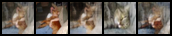

 12%|█▏        | 589/5000 [00:04<00:35, 123.52it/s]

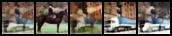

 18%|█▊        | 892/5000 [00:07<00:33, 124.26it/s]

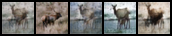

 24%|██▍       | 1192/5000 [00:09<00:31, 120.55it/s]

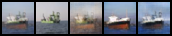

 30%|██▉       | 1494/5000 [00:12<00:28, 124.26it/s]

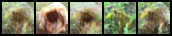

 36%|███▌      | 1795/5000 [00:14<00:26, 122.52it/s]

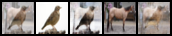

 42%|████▏     | 2097/5000 [00:17<00:24, 119.86it/s]

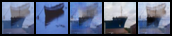

 48%|████▊     | 2394/5000 [00:19<00:21, 123.41it/s]

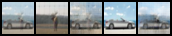

 54%|█████▍    | 2692/5000 [00:22<00:19, 119.91it/s]

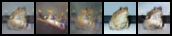

 60%|█████▉    | 2988/5000 [00:24<00:16, 124.44it/s]

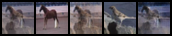

 66%|██████▌   | 3299/5000 [00:27<00:13, 121.94it/s]

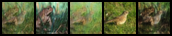

 72%|███████▏  | 3599/5000 [00:29<00:12, 116.62it/s]

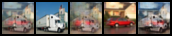

 78%|███████▊  | 3894/5000 [00:32<00:08, 123.43it/s]

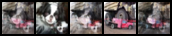

 84%|████████▍ | 4196/5000 [00:34<00:06, 120.02it/s]

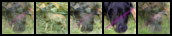

 90%|████████▉ | 4489/5000 [00:37<00:04, 121.48it/s]

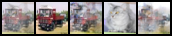

 96%|█████████▌| 4795/5000 [00:39<00:01, 120.29it/s]

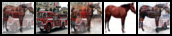

100%|██████████| 5000/5000 [00:41<00:00, 120.93it/s]



MSE :0.0313, PSNR: :15.5046, SSIM: :0.5985




In [ ]:
# Testing 

#Please change accordingly

#uncomment if downloaded a pretrained model
model.load_state_dict(torch.load('./PretrainModels/2DecodersSSIM_epoch100.pth'))
# model.load_state_dict(torch.load('./PretrainModels/2DecodersSSIM_epoch400.pth'))

#uncomment if not downloaded a pretrained model
# model.load_state_dict(torch.load('./PretrainModels/AE_model_1.pth'))


model.eval()


#initialization
Evaluate(test_dataloader, model, True)

